# MLP 모델을 설계하는 순서
## 모듈 임포트하기
## 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
## MNIST 데이터 다운로드 하기 
## 데이터 확인하기
## 데이터 확인하기
## MLP 모델 설계하기
## optimizer, Objective Function
## MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
## 학습되는 과정 속에서 거믕 데이터에 대한 모델의 성능을 확인하는 함수 정의하기
## MLP 학습을 실행하면서 Train, Test set 의 Loss 및 Test set Accuracy 확인하기 

In [21]:
# Module Import

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [22]:
# 설계할 때 활용하는 장ㅂ ㅣ확인 
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('mps')
else:
    DEVICE = torch.device('cpu')
    print("cpu")
    
print('Using PyTorch version : ', torch.__version__, 'Deviece :', DEVICE )

mps
Using PyTorch version :  2.9.1 Deviece : mps


In [23]:
BATCH_SIZE = 32 # 한번 계산 할 때 사용할 데이터 수 
EPOCHS = 10 # 한번 전체를 도는 것이 epochs

In [24]:
# MNIST 데이터 다운로드 (Train Test Split)
train_dataset = datasets.MNIST(root = "../data/MNIST", 
                               train = True, 
                               download = True, 
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST", 
                               train = False,  
                               transform = transforms.ToTensor()) # 이미지 파일을 tensor형태로 변경, 한 픽셀은 0 ~ 255 범위의 스칼라 값으로 구성, 이를 0 ~ 1 범위로 정규화

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = BATCH_SIZE, #Batch_Size 만큼 데이터를 묶어 1개의 Mini-Batch 구성하기 위해 loader 구성
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = False)

# loader을 구성하는 이유는 미니배치로 구성하기 위해 사용

In [25]:
# 데이터 확인하기 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break


# X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor -> 32개의 이미지가 하나의 배치/ 그 이미지는 28 * 28 픽셀의 형태 
# y_train: torch.Size([32]) type: torch.LongTensor -> 이미지 하나당 하나의 레이블을 차지하므로, 한 배치의 레이블 수는 32개가 된다. 

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


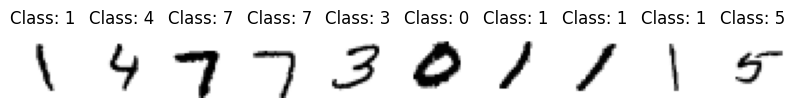

In [26]:
# 데이터 확인하기 2
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [27]:
# MLP 모델 설계하기 (Forward propagation)

class Net(nn.Module):                      
    def __init__(self):                     
        super(Net, self).__init__()         # nn.Module 내에 있는 메서드를 상속 받아 이용할 수 있게끔
        self.fc1 = nn.Linear(28*28, 512)    # 각 Fully Connected Layer 정의 (input, output)
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 10)       
    def forward(self, x) :                  # Forward propagation 정의
        x = x.view(-1, 28 * 28)             # MLP는 1차원 데이터만 받지만, 이미지는 2차원데이터 값 => view 메서드를 통해 784 크기의 1차원 데이터로 변환해 진행해야한다. : Flatten 한다 
        x = self.fc1(x)                     # __init__() 메서드를 이용해 정의한 첫번째 Fully Connected Layer에 1차원으로 펼친 이미지 넣기
        x = F.sigmoid(x)                    # 시그모이드 함수 써서 INPUT으로 변환
        x = self.fc2(x)                     
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)       # log_softmax를 이용해 확률값 계산 => Loss값에 대한 gradient를 원할하게 계산할 수 있기 때문
        return x
    

# 여기서 class의 의미 : Net이 호출되면 이하의 정의한 함수들을 실행한다는 의미

# class를 왜 쓰는가? 그래야 gradient 기록? 이 가능하다. 
    # vs def : def는 기록 안됨. class는 기록 가능 

# Dropout + ReLU 함수 적용 방법
class Net(nn.Module):                      
    def __init__(self):                     
        super(Net, self).__init__()         
        self.fc1 = nn.Linear(28*28, 512)    
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5             # 퍼센트 설정
               
    def forward(self, x) :                  
        x = x.view(-1, 28 * 28)             
        x = self.fc1(x)                     
        x = F.relu(x)                       # ReLU 함수 적용
        x = F.dropout(x, training = self.training, p = self.dropout_prob)   # dropout 적용                 
        x = self.fc2(x)
        x = F.relu(x)                       # ReLU 함수 적용 
        x = F.dropout(x, training = self.training, p = self.dropout_prob)   # dropout 적용
        x = self.fc3(x)ㄴ
        x = F.log_softmax(x, dim = 1)       
        return x
    
# Batch Normalization 적용해보기 
class Net(nn.Module):                      
    def __init__(self):                     
        super(Net, self).__init__()         
        self.fc1 = nn.Linear(28*28, 512)    
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNormld(512)  # output 값으로 설정
        self.batch_norm2 = nn.BatchNormld(256)  # output 값으로 설정           
               
    def forward(self, x) :                  
        x = x.view(-1, 28 * 28)             
        x = self.fc1(x)       
        x = self.batch_norm1(x)             # input 넣기 전 표준화
        x = F.relu(x)                       
        x = F.dropout(x, training = self.training, p = self.dropout_prob)                    
        x = self.fc2(x)
        x= self.batch_norm2(x)              # input 넣기 전 표준화
        x = F.relu(x)                       
        x = F.dropout(x, training = self.training, p = self.dropout_prob)  
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)       
        return x

In [32]:
# optimizer, Objective Function 설정하기 (Back propagation)
model = Net().to(DEVICE)                    # DEVICE에 MLP 모델 할당
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)  # Back Propagation을 이용해 파라미터를 업데이트 할 때 Optimizer 정의 : SGD
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 모델 사용
criterion = nn.CrossEntropyLoss()           # 벌점 이런거 주기 

print(model)


# momentum은 무슨 파라미터일까? 
    # optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
        # model.parameters(): 대상 설정
        # lr : 학습률
        # momentum : 방향성 파라미터, 수치 조절 의미는 과거의 경험을 얼마나 비중 있게 믿을 것인가? 
# 다른 optimizer 은 뭐가 있을까? 
    # Adagrad : 자주 변하는 가중치는 보폭을 줄이고, 드물게 변하는건 보폭을 넓혀서 꼼곰하게
    # RMSProp : Adagrad의 단점인 나중에 학습이 멈추는 현상 보완
    # Adam : Momentum + RMSProp : 관성도 있고 보폭도 알아서 조절하는 가장 똑똑한 엔진 (대체적으로 많이 사용)
# criterion은 뭘까? => Loss 계산 위해서 ....
# CrossEntropy는 뭘까? 
    # 정답과 예측값의 확률이 얼마나 겹치치 않는지를 확인 : 많이 겹칠수록 벌점이 적고, 멀어질수록 기하급수적으로 커짐
    # 로그를 씌움 : 맞으면 벌점 X, 틀리면 벌점 더 큼


# optimizer, Objective Function 설정하기2 (He Initialization)
import torch.nn as isinstance
def weight_init(m)
    if isinstance(m, nn.Linear):            # nn.Linear에 해당하는 파라미터값만 지정
        init.kaiming_uniform_(m.weight.data)# he_initialization 을 이용해 파라미터값 초기화 (kaiming_uniform(m.weight.data) = He initialization)

model = Net().to(DEVICE)                    
model.apply(weight_init)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()         


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [29]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 
def train(model, train_loader, optimizer, log_interval): 
    model.train()                           # MLP을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):   # Mini-Batch 단위로 이미지 데이터가 묶여있음. => 순서대로 MLP 모형 학습
        image = image.to(DEVICE)            # 이미지 -> 장치에 할당
        label = label.to(DEVICE)            # 라벨 -> 장치에 할당
        optimizer.zero_grad()               # 지난번 할당한 것 지우는 것 
        
        output = model(image)               # 이미지 데이터를 인풋으로 모델을 돌려 아웃풋 계산
        loss = criterion(output, label)     # Loss funtion 작동
        loss.backward()                     # (auto_grad)계산된 gradient 값을 각 파라미터에 할당
        optimizer.step()                    # 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{} / {}({:.0f}%)]\tTrain Loss: {:6f}".format(Epoch, batch_idx * len(image), 
                                                                                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                                  loss.item()))
            
            


In [30]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 
def evaluate(model, test_loader):
    model.eval()                            # 모델을 평가상태로 지정
    test_loss = 0                           # Loss 계산하기 위한 초기 설정
    correct = 0                             # 올바르게 분류한 경우 세기 위한 초기설정
    
    with torch.no_grad():                   # gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:    # Mini-batch 내에 있는 이미지 데이터와 레이블 데이터에 접근
            image = image.to(DEVICE)        
            label = label.to(DEVICE)
            output = model(image)           # 모델의 output 계산
            test_loss += criterion(output, label).item()    # 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 계산된 걸 test_loss
            prediction = output.max(1, keepdim = True)[1]   # 계산된 벡터값 내 가장 큰 값인 위치에 해대 해당하는 위치에 대응하는 클래스로 예측 
            correct += prediction.eq(label.view_as(prediction)).sum().item() # correct에 맞춘 것 수 저장
            
    test_loss /= len(test_loader.dataset)   # test_loss를 mini-batch 개수만큼 나눠 평균 Loss값으로 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)   # 정답률
    return test_loss, test_accuracy

# .eval() : 평가모드로 바꿔주는 코드 vs .train()

# 답지.view as(예측값) : 정답지하고 '모양' 똑같이 맞추기

# 예측값.eq(답지) : 답지와 예측값이 맞는지 안맞는지 / T&F와 동일하게 출력(0, 1)  

# with : 해당 루프 허용된 특수한 업무(파일 읽기, 기울기 계산 끄기 등)를 수행


In [31]:
# MLP 학습을 실행하면서 Train, Test  set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))
    

# 여기서 log_interval은 뭘까?

# 
    

Train Epoch : 1 [0 / 60000(0%)]	Train Loss: 2.526221
Train Epoch : 1 [6400 / 60000(11%)]	Train Loss: 2.321574
Train Epoch : 1 [12800 / 60000(21%)]	Train Loss: 2.348643
Train Epoch : 1 [19200 / 60000(32%)]	Train Loss: 2.311108
Train Epoch : 1 [25600 / 60000(43%)]	Train Loss: 2.283933
Train Epoch : 1 [32000 / 60000(53%)]	Train Loss: 2.313536
Train Epoch : 1 [38400 / 60000(64%)]	Train Loss: 2.260909
Train Epoch : 1 [44800 / 60000(75%)]	Train Loss: 2.299784
Train Epoch : 1 [51200 / 60000(85%)]	Train Loss: 2.256424
Train Epoch : 1 [57600 / 60000(96%)]	Train Loss: 2.264182

[EPOCH: 1], 	Test Loss: 0.0700, 	Test Accuracy: 15.57 %

Train Epoch : 2 [0 / 60000(0%)]	Train Loss: 2.251606
Train Epoch : 2 [6400 / 60000(11%)]	Train Loss: 2.173314
Train Epoch : 2 [12800 / 60000(21%)]	Train Loss: 2.206167
Train Epoch : 2 [19200 / 60000(32%)]	Train Loss: 2.130026
Train Epoch : 2 [25600 / 60000(43%)]	Train Loss: 1.887710
Train Epoch : 2 [32000 / 60000(53%)]	Train Loss: 1.908029
Train Epoch : 2 [38400 / 6